# Figure 2 - CMIP6 changes in extreme temperatures
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data locations

In [2]:
loc_panel = "../Data/Panel/"
loc_regression = "../Data/RegressionResults/"
loc_shp = "../Data/Shapefile/"
loc_cmip6_tx = "../Data/CMIP6/RegionTx/"

#### Analysis

Get shapefile for plotting regions

In [3]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})

Read panel to get scalings

In [4]:
edd_type = "month"
extr = "tx5d"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)

Get CMIP6 data and smooth

In [5]:
ssp = "ssp245"
y1_cmip6 = 1950
y2_cmip6 = 2020
models = np.array([x.split("_")[0]+"_"+x.split("_")[1] for x in sorted(os.listdir(loc_cmip6_tx)) if ("historical-"+ssp in x)&(str(y1_cmip6)+"-"+str(y2_cmip6) in x)])
cmip6_hist_tx = xr.open_mfdataset(loc_cmip6_tx+"*_historical-"+ssp+"*_"+str(y1_cmip6)+"-"+str(y2_cmip6)+".nc",
                                 combine="nested",concat_dim="model").data_vars[extr].load()
cmip6_histnat_tx = xr.open_mfdataset(loc_cmip6_tx+"*_historical-nat_*_"+str(y1_cmip6)+"-"+str(y2_cmip6)+".nc",
                                 combine="nested",concat_dim="model").data_vars[extr].load()
cmip6_hist_tx.coords["model"] = models
cmip6_hist_tx.coords["time"] = np.arange(y1_cmip6,y2_cmip6+1,1)
cmip6_histnat_tx.coords["model"] = models
cmip6_histnat_tx.coords["time"] = np.arange(y1_cmip6,y2_cmip6+1,1)

In [6]:
smth = 15
cmip6_hist_tx_smooth = cmip6_hist_tx.rolling(time=smth,min_periods=smth,center=True).mean()
del(cmip6_hist_tx)
cmip6_histnat_tx_smooth = cmip6_histnat_tx.rolling(time=smth,min_periods=smth,center=True).mean()
del(cmip6_histnat_tx)

Calculate counterfactual Tx

In [7]:
obs_tx = panel.loc[:,["region","time",extr]].pivot(index="region",columns="time")
obs_tx = xr.DataArray(obs_tx.values,
                    coords=[np.unique(panel.region.values),
                            np.unique(panel.time.values)],
                    dims=["region","time"])
cmip6_tx_diff = cmip6_hist_tx_smooth - cmip6_histnat_tx_smooth
del([cmip6_hist_tx_smooth,cmip6_histnat_tx_smooth])
cf_tx = obs_tx - cmip6_tx_diff
modelnames = xr.DataArray(np.array([x.split("_")[0] for x in models]),coords=[models],dims=["model"])
cf_tx.coords["modelname"] = modelnames

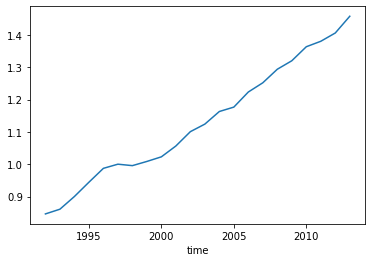

In [8]:
cmip6_tx_diff[:,["BRA" in x for x in cmip6_tx_diff.region.values],:].loc[:,:,1992:2013].mean(dim=["model","region"]).plot()

In [9]:
# average across realizations within each model
cf_tx_mdl = cf_tx.groupby("modelname").mean()
# then overall ensemble mean
cf_tx_em = cf_tx_mdl.mean(dim="modelname")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Final years

In [10]:
y1_final = 1992
y2_final = 2013

Calculate change in average and extreme Tx5d

In [11]:
average_change_em = obs_tx.loc[:,y1_final:y2_final].mean(dim='time') - cf_tx_em.loc[:,y1_final:y2_final].mean(dim="time")

In [12]:
p_cf = ((cf_tx_em.loc[:,y1_final:y2_final] >= cf_tx_em.loc[:,y1_final:y2_final].quantile(0.9,dim="time"))*100).mean(dim="time")
p_obs = ((obs_tx.loc[:,y1_final:y2_final] >= cf_tx_em.loc[:,y1_final:y2_final].quantile(0.9,dim="time"))*100).mean(dim="time")
#p_cf = (cf_tx_em >= cf_tx_em.max(dim="time")).mean(dim="time")
#p_obs = (obs_tx >= cf_tx_em.max(dim="time")).mean(dim="time")
p_change = p_obs - p_cf
p_change_pct = 100*(p_obs - p_cf)/p_cf
p_change_ratio = p_obs/p_cf

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [13]:
notna_regions = cf_tx_em[:,-2][~np.isnan(cf_tx_em[:,-2])].region
na_regions = cf_tx_em[:,-2][np.isnan(cf_tx_em[:,-2])].region

In [14]:
delta_na = average_change_em[~np.isnan(average_change_em)]
print(len(delta_na[delta_na>0])/len(delta_na))

0.9922178988326849


Plot

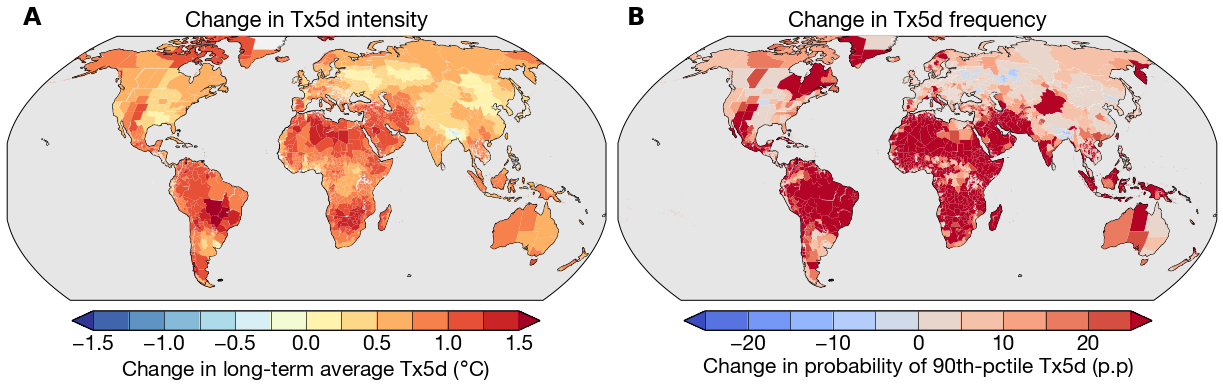

In [15]:
fig = plt.figure(figsize=(20,10))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.12,right=0.96,top=0.9,bottom=0.2,wspace=0.02,hspace=0.3)

## now map

for j in [1,2]:
    ax = plt.subplot(gs2[0,j-1],projection=ccrs.Robinson())
    ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
    ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.98,0.98,0.98])

    # set colors
    if j == 1:
        vmin = -1.5
        vmax = 1.5
        ncol = 13 # choose a number greater than
                  # the number of colors you actually want
        bounds = np.linspace(vmin,vmax,ncol)
        cmapname = 'RdYlBu_r'
        cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
    else:
        # choose color levels
        vmin = -25
        vmax = 25
        ncol = 11
        bounds = np.linspace(vmin,vmax,ncol)
        cmapname = 'coolwarm'
        cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

    
    # plot geoms
    
    if j == 1:
        vals = average_change_em
    else:
        vals = p_change
    baseline_col = [0.95,0.95,0.95]
    for i in shp.region:
        geom = shp.loc[shp.region==i,"geometry"]
        val = vals.loc[i]
        col = cbar.to_rgba(val)
        if (~np.isnan(val)):
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                         edgecolor="black",linewidth=0,zorder=10)
        else:
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                         edgecolor="black",linewidth=0)
    
    
    # colorbar and title
    tfs = 22
    b = 0.325
    w = 0.325
    h = 0.027
    if j == 1:
        l = 0.165
        plt.title("Change in Tx5d intensity",pad=10,fontsize=tfs)
        #tks = [0,2,4,6,8,10]
    else:
        l = 0.59
        plt.title("Change in Tx5d frequency",pad=10,fontsize=tfs)
        #tks = [0,0.1,0.2,0.3,0.4]
    
    cbar_ax = fig.add_axes([l,b,w,h])
    
    # colorbar
    cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                      drawedges=True,extend="both")
    cbar_ax.tick_params(direction="in",width=0.05)
    
    if j == 1:
        cb.set_label("Change in long-term average Tx5d ($\degree$C)")
    else:
        cb.set_label("Change in probability of 90th-pctile Tx5d (p.p)")


plt.figtext(0.13,0.75,r"$\bf{A}$",fontsize=24)
plt.figtext(0.55,0.75,r"$\bf{B}$",fontsize=24)

plt.savefig("../Figures/Fig2.png",dpi=600)
plt.show()

get some numbers here

In [25]:
np.nanmean(average_change_em[average_change_em!=0])

0.7711871708728338

In [27]:
np.nanmean(p_change)

12.844371694787206